First, we load our data, the EMA trajectory $X = x_1,\dotsc,x_T$ and the inputs $U = u_1,\dotsc,u_T$. In this tutorial, we generate some data from a random VAR(1) model. Feel free to replace it with your own data if you like (make sure it has the correct shape). The EMA data point $x_t$ is a vector with $15$ elements, representing $15$ variables. The input $u_t$ is a unit vector with $4$ elements, each representing one of $4$ possible inputs.

In [1]:
from ctrl import discrete_optimal_control as doc
from ctrl import utils
import numpy as np
import matplotlib.pyplot as plt

dataset = utils.generate_random_dataset(1, 100)
X, U = dataset[0]['X'], dataset[0]['Inp']
# Shape of the EMA data: (time x EMA variables)
# Shape of the inputs: (time x input)

Then, we fit a VAR(1) model $$x_{t+1} = Ax_t + Bu_t $$ to the data using ridge regression. Note that $B$ specifies the way the inputs $u_t$ act on the system.

In [2]:
A, B, lmbda = utils.stable_ridge_regression(X, U)     # the lmbda output is the regularization parameter that is used to render A stable
n_variables = B.shape[0]        # for convenience
n_inputs = B.shape[1]           # for convenience

We can use the `circular_graph` method to get a representation of the VAR model as a graph.

''

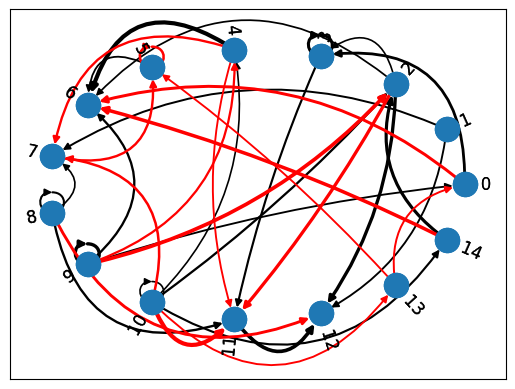

In [3]:
A_positive = np.clip(A, 0, None)        # We plot positive and negative connections separately in different colors
A_positive[A_positive < 0.3] = 0        # We omit weak connections to make the graph less cluttered.
A_negative = (-1) * np.clip(A, None, 0)
A_negative[A_negative < 0.3] = 0
utils.plot_circular_graph(A_positive, directed=True, edge_kwargs={'edge_color':'black'})
utils.plot_circular_graph(A_negative, directed=True, edge_kwargs={'edge_color':'red'})
;

The colorplot_trajectory methods creates an overview plot over the data. We can also use it to visualize the inputs.

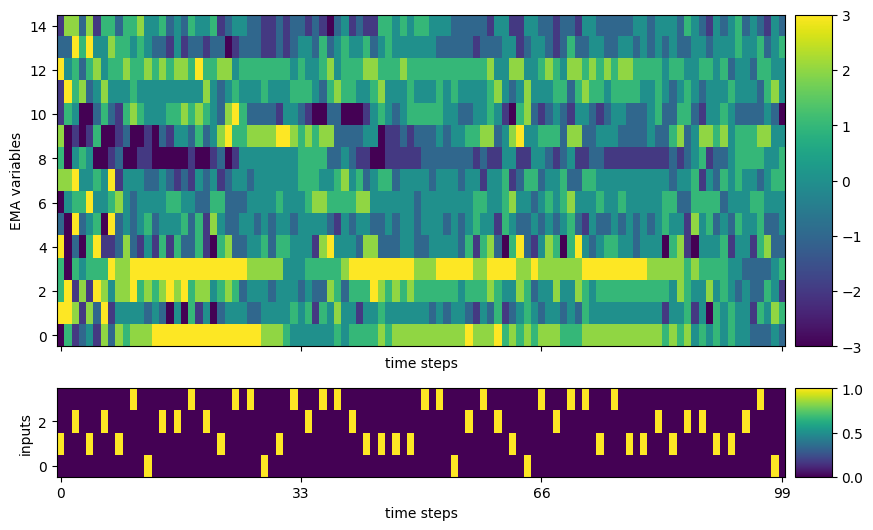

In [4]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(10,6), height_ratios=(15,4))
utils.colorplot_trajectory(X, ax=axes[0], aspect='auto', origin='lower')
axes[0].set_ylabel('EMA variables')
utils.colorplot_trajectory(U, ax=axes[1], aspect='auto', origin='lower')
axes[1].set_ylabel('inputs');

Check whether the estimated system is controllable via the presented inputs individually, and with all inputs combined.

In [5]:
for k in range(n_inputs):
    ctrlb = doc.controllable(A, B[:,k])             # For a single output, take the respective column in B.
    print(f'Controllable via input {k}? {ctrlb}')
ctrlb = doc.controllable(A, B)                      # For all outputs, use the complete B matrix.
print(f'Controllable via all inputs combined? {ctrlb}')

Controllable via input 0? False
Controllable via input 1? False
Controllable via input 2? False
Controllable via input 3? False
Controllable via all inputs combined? True


Average controllability is more nuanced: we use it to quantify the effect of allocating control input to individual nodes (variables).

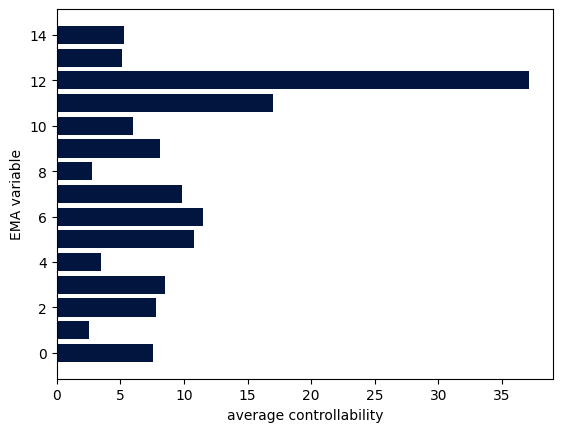

In [6]:
ac = doc.average_ctrb(A)
plt.barh(range(n_variables), ac, color='#01153E')
plt.ylabel('EMA variable')
plt.xlabel('average controllability');

The cumulative impulse response (CIR) quantifies the cumulative effect of an input over time on the individual nodes. For interpretation, consider which direction of impulse response is desirable (in our case: negative). CIR reveals at a glance the ambiguity of effects of an input. 

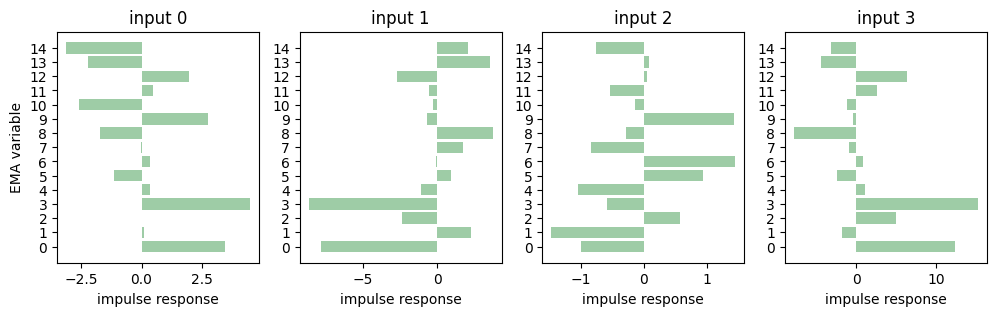

In [7]:
fig, axes = plt.subplots(1, n_inputs, figsize=(12,3))
for k in range(n_inputs):
    cir = doc.cumulative_impulse_response(A, B[:,k], T=100)          # T is the number of timesteps over which the impulse response will be accumulated. Choice depends on theoretical question.
    axes[k].barh(range(n_variables), cir, color='#9ecca6')
    axes[k].set(xlabel='impulse response', yticks=range(n_variables), title=f'input {k}')
axes[0].set_ylabel('EMA variable');

We can simulate interventions by customizing the input matrix $B$. Setting it to a unit colums vector $[0,\dotsc,0,1,0,\dotsc,0]$ will result in an intervention that targets a single node only (depending on the position of the $1$). E.g., we can target the highest average controllability node. The cumulative impulse response here is usually more pronounced.

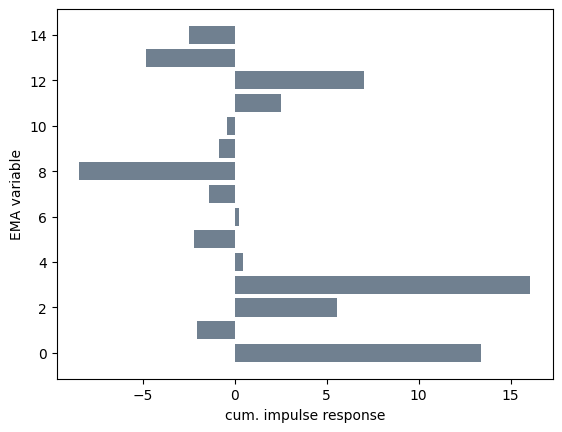

In [8]:
max_ac_node = np.argmax(ac)         # Highest average controllability node
cir = doc.cumulative_impulse_response(A, np.eye(n_variables)[max_ac_node], 100)        # Set B to a unit vector 
plt.barh(range(n_variables), cir, color='slategrey')
plt.xlabel('cum. impulse response')
plt.ylabel('EMA variable');

Let's calculate the theoretical optimal control $u^*$. Optimality refers to minimizing the loss function
$$L = (x_T - r_T)^\top Q (x_T - r_T)
    + \sum_{t=0}^{T-1}\left((x_t-r_t)^\top Q (x_t-r_t) + u_t^\top R u_t)\right). $$
    
For this, we need to define a reference trajectory $r_t$: the most desirable trajectory possible. In our case this would be a trajectory that is constantly $-3$ on all its variables.
The optimal control tries to push the trajectory closer to the reference trajectory while minimizing the cost of control input.
Also, we need to specify the positive definite matrices $Q$, definining the cost of deviation from the reference trajectory, and $R$, defining the cost of control input. Usually the natural choice are identity matrices times a factor, and since these are relative costs, we can set $Q=I$ and $R=\rho I$. $\rho$ then defines relative control cost in a single parameter.

We use the `colorplot_trajectory` method to visualize the optimal control $u^*$.

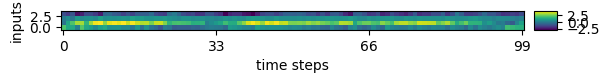

In [9]:
reference = -3 * np.ones_like(X)
rho = 1                     # rho=1 means that control input and trajectory deviation are weighted equally in the loss function.
Q = np.eye(n_variables)
R = np.eye(n_inputs) * rho
optimal_control = doc.tracking_optimal_control(A, B, Q, R, X, reference)
ax, colorbar = utils.colorplot_trajectory(optimal_control, origin='lower')
ax.set_ylabel('inputs');

Of course, it's unrealistic to apply this optimal control in practice, as the control input must be indicator variables (it cannot be arbitrarily scaled). However, it gives an indication on how much emphasis one should put on different control inputs to achieve optimal results. 

As with the impulse response, we can simulate targeting nodes individually, and calculate the optimal control under this assumption. For this, we set the input matrix $B$ to be the identity matrix. 

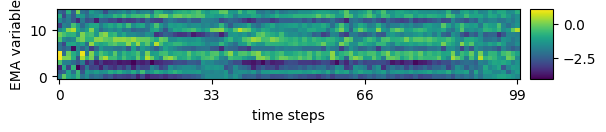

In [10]:
R = np.eye(n_variables) * rho
optimal_control = doc.tracking_optimal_control(A, np.eye(n_variables), Q, R, X, reference)
ax, colorbar = utils.colorplot_trajectory(optimal_control, origin='lower')
ax.set_ylabel('EMA variable');

Control energy is the mean squared control input over time:
$$ E_{\text{control}} = \frac{1}{T} \sum_{t=0}^{T-1} u_t^2 $$
The control energy of the optimal control heuristically indicates which individual EMA variables should be targeted by an input in order to approach the reference trajectory.

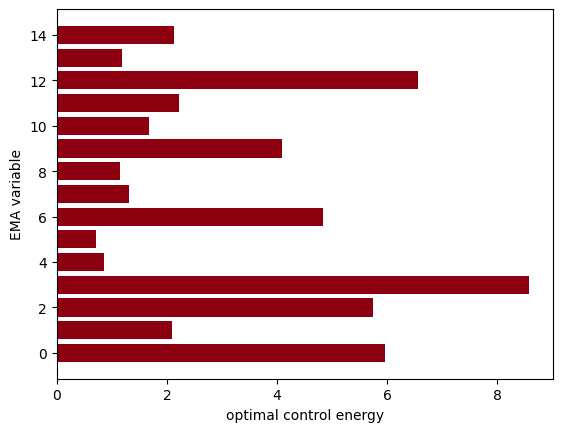

In [11]:
control_energy = (optimal_control**2).mean(axis=0)
plt.barh(range(n_variables), control_energy, color='#8C000F')
plt.xlabel('optimal control energy')
plt.ylabel('EMA variable');

We investigate the relationship between the allocation of control energy and AC. For this, we sort the nodes (EMA variables) by AC, and plot control energy on the nodes in the respective order.

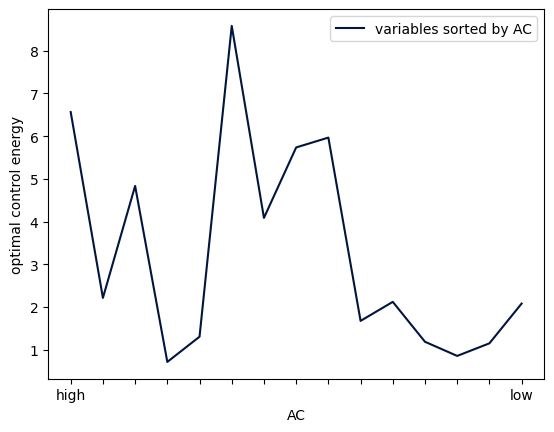

In [14]:
AC_order = np.argsort(ac)[::-1]
energy_sorted_by_AC = control_energy[AC_order]
line1, = plt.plot(range(n_variables), energy_sorted_by_AC, color='#01153E')
plt.xticks(range(n_variables), labels=(['high']+['']*(n_variables-2)+['low']))
plt.ylabel('optimal control energy')
plt.xlabel('AC')
plt.legend([line1], ['variables sorted by AC']);

Now we can increase $\rho$ to make control input more expensive compared to deviation from the actual trajectory. 

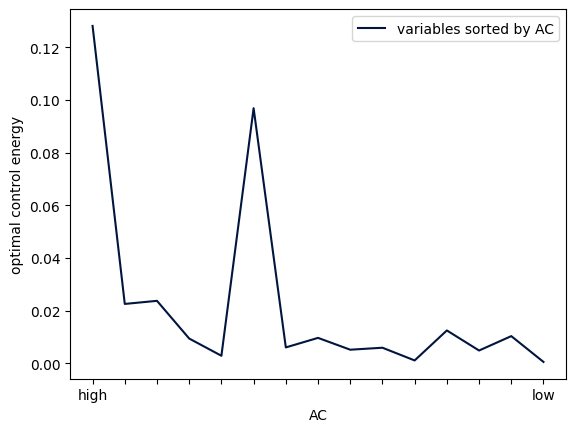

In [15]:
rho = 100
R = np.eye(n_variables) * rho
optimal_control = doc.tracking_optimal_control(A, np.eye(n_variables), Q, R, X, reference)
control_energy = (optimal_control**2).mean(axis=0)
energy_sorted_by_AC = control_energy[AC_order]
line1, = plt.plot(range(n_variables), energy_sorted_by_AC, color='#01153E')
plt.xticks(range(n_variables), labels=(['high']+['']*(n_variables-2)+['low']))
plt.ylabel('optimal control energy')
plt.xlabel('AC')
plt.legend([line1], ['variables sorted by AC']);

We found that $\rho = 100$ results in control energies of the same order of magnitude as the actually employed control energy. The optimal control algorithm tends to allocate more control energy on high AC items in this scenario. Accordingly, we conclude that in order to design effective new inputs, they should target high AC nodes.

Now we want to leverage the knowledge we've got to find a strategy to select EMI from the set of admissible EMI that we have. For this, we'll pretend we only have recorded the data until time step 50. Let's use the optimal control strategy to find an input for this time step. We choose $\rho=80$ as in the paper.

In [21]:
from ctrl import control_strategies as strategies

admissible_inputs = np.eye(n_inputs)
target_state = np.ones(n_variables) * (-3)
u = strategies.optimal_control_strategy(X[:50], U[:50], target_state, admissible_inputs, 80, online=True)
u

array([[0., 1., 0., 0.]])

Now let's pretend we're progressing on from time 50 to time 100. For each time step, we want to select a control input. We can only use the information, a.k.a. the data, available until this time point. In an event sampling study, the strategies could be deployed like this. Let's use the max AC strategy.

''

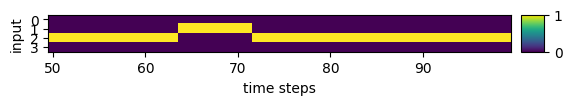

In [28]:
time_horizon = np.arange(50, 100)
u_sequence = np.zeros((len(time_horizon), n_inputs))
for t, timestep in enumerate(time_horizon):
    u_sequence[t] = strategies.max_ac_strategy(X[:timestep], U[:timestep], admissible_inputs, online=True)
ax, _ = utils.colorplot_trajectory(u_sequence)
ax.set(xticks=np.arange(0, len(time_horizon), 10), xticklabels=time_horizon[::10], yticks=np.arange(n_inputs), ylabel='input')
;